#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 세가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : 사전학습된 Word2Vec 모델을 로딩하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기
* 챗봇3. 단계별 모델링2
    * 1단계 : 챗봇2의 1단계 모델을 그대로 활용
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇3개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 3.8.3 설치

In [1]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
# 현재 4.x 버전이 최신이지만, 3.8.3 버전으로 진행
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26528035 sha256=abc15d11a787436650c72daf46453a1936f7a3aed05d51f9cd23fba4a9d3f563
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


* [코랩] 위 라이브러리 설치후 런타임 재시작 필요!

#### 2) 형태소 분석을 위한 라이브러리

In [2]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Buil

In [3]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 43.2 MB/s eta 0:00:00
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1267k      0  0:00:01  0:00:01 --:--:-- 2246k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1


### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import * 

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity



* 형태소 분석을 위한 함수를 제공합니다.

In [5]:
# 1. 특수문자 제거
import re

def remove_special_chars(text):
    # 한글, 알파벳, 숫자를 제외한 모든 문자 제거
    text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\\s]", "", text)
    # 공백을 기준으로 단어 분리
    text = " ".join(text.split())
    return text

In [6]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()
        
    return tokenizer

In [7]:
# 2. 형태소 분석기 사용
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # 특수문자 제거
    sentence = remove_special_chars(original_sent)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    # sentence = original_sent.replace('\n', '').strip() # 줄바꿈 단위로 문장 판단 
    if nouns:       
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions

* 구글 드라이브 연결

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/KT aivleschool/KT_aivle_school_AI_track/16. MINI_PJ6/'

* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [10]:
import joblib

train = joblib.load(path + 'train.pkl')
test = joblib.load(path + 'test.pkl')
clean_train_question = joblib.load(path + 'clean_train_questions.pkl')
clean_test_question = joblib.load(path + 'clean_test_questions.pkl')


In [11]:
print(train.shape)
print(test.shape)
print(clean_train_question.shape)
print(clean_test_question.shape)

(1156, 4)
(106, 4)
(1156,)
(106,)


In [12]:
train.tail()

,intent,Q,A,type
786,53,다른 국비지원과 비교할 때 차이가 뭔가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
791,53,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


In [32]:
clean_train_question.tail()

786           다른 국비 지원 과 비교 할 때 차이 가 뭔 가요
788                다른 교육 과 의 차이점 은 무엇 인가요
789                    다른 교육 과 차이점 이 있 나요
790    다른 국비 지원 교육 보다 특별 한 점 이 있 는지 궁금 해요
791                다른 교육 보다 특별 한 것 이 있 나요
Name: Q, dtype: object

## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [14]:
tokenizer_names = ["mecab"]
for tokenizer_name in tokenizer_names:
    print(f"--- Tokenizer: {tokenizer_name} ---")
    for sent in train['Q']:
        tokenized_sent = tokenize(tokenizer_name, sent)
        print(f"원본 문장: {sent}")
        print(f"토큰화된 문장: {tokenized_sent}")
    print("\n")

--- Tokenizer: mecab ---
원본 문장: 떨어뜨려서 핸드폰 액정 나갔어
토큰화된 문장: 떨어뜨려서 핸드폰 액정 나갔 어
원본 문장: 액정 나갔어
토큰화된 문장: 액정 나갔 어
원본 문장: 핸드폰 떨어뜨려서 고장 났나봐
토큰화된 문장: 핸드폰 떨어뜨려서 고장 났 나 봐
원본 문장: 노트북 키보드가 안먹히네
토큰화된 문장: 노트북 키보드 가 안 먹히 네
원본 문장: 노트북 전원이 안들어와.
토큰화된 문장: 노트북 전원 이 안 들어와
원본 문장: 컴퓨터가 제대로 작동하지 않아요
토큰화된 문장: 컴퓨터 가 제대로 작동 하 지 않 아요
원본 문장: 컴퓨터가 에러 메시지를 띄우고 있어요.
토큰화된 문장: 컴퓨터 가 에러 메시지 를 띄우 고 있 어요
원본 문장: 컴터 고장났나봐
토큰화된 문장: 컴 터 고장났 나 봐
원본 문장: 컴터가 맛이 갔어
토큰화된 문장: 컴 터 가 맛 이 갔 어
원본 문장: 컴터가 안돼
토큰화된 문장: 컴 터 가 안 돼
원본 문장: 핸드폰 고장났나봐
토큰화된 문장: 핸드폰 고장났 나 봐
원본 문장: 핸드폰 맛이 갔어
토큰화된 문장: 핸드폰 맛 이 갔 어
원본 문장: 핸드폰 안돼
토큰화된 문장: 핸드폰 안 돼
원본 문장: 노트북 안돼
토큰화된 문장: 노트북 안 돼
원본 문장: 내 의지는 상관없나봐
토큰화된 문장: 내 의지 는 상관없 나 봐
원본 문장: 내 의지로 안되는 일인가봐
토큰화된 문장: 내 의 지로 안 되 는 일 인가 봐
원본 문장: 건강이 최고
토큰화된 문장: 건강 이 최고
원본 문장: 건강이 최고인 것 같아
토큰화된 문장: 건강 이 최고 인 것 같 아
원본 문장: 아프면 안 되는데
토큰화된 문장: 아프 면 안 되 는데
원본 문장: 올해도 건강하길
토큰화된 문장: 올해 도 건강 하 길
원본 문장: 올해도 행복하길
토큰화된 문장: 올해 도 행복 하 길
원본 문장: 올해 합격하길
토큰화된 문장: 올해 합격 하 길
원본 문장: 건강이 최고야
토큰화된 문장: 건강 이 최고 야
원본 문장: 이번년도는 꼭 집을 장만할거야
토큰화된 문장:

In [15]:
train_tokenize = train["Q"].apply(lambda x: tokenize('mecab', x))

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원), 
    * window(컨텍스트 창의 크기), 
    * max_vocab_size(고려할 최대 어휘 크기), 
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [16]:
import gensim
from gensim.models import Word2Vec
import multiprocessing

# 문장 리스트를 토큰화하여 모델 입력 데이터로 변환
tokenized_sentences = [tokenize('mecab', sentence) for sentence in train['Q']]

# Word2Vec 모델 생성 및 학습
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    size=100, # 임베딩 벡터의 차원
    window=5, # 컨텍스트 창의 크기
    min_count=5, # 최소 단어 빈도
    sg=1, # 훈련 알고리즘 (1: skip-gram, 0: CBOW)
    workers=multiprocessing.cpu_count(),
    iter=50 # Epoch 수
)

# 학습된 모델 저장
w2v_model.save('w2v_model.model')


In [17]:
# from gensim.models import Word2Vec

# # Word2Vec 모델 생성
# wv_model = Word2Vec(                   )

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [18]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.index2word)
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model[word])
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [19]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)
    
    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [20]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(train['Q'], w2v_model, 100)

# 인자 설명 
# 1 - 학습데이터에서 질문에 해당하는 열
# 2 - word2vec 모델 객체
# 3- word2vec 모델에서 지정한 임베딩 벡터의 크기
# 이 코드를 실행하면 모든 질문들이 Word2Vec 모델을 사용하여 벡터화된 후 2차원 np 배열로 저장됨
# train_data_vecs = get_dataset(data['Q'], model, embedding_size)

In [21]:
train_data_vecs[:3]

array([[ 2.38681361e-01,  1.67030320e-01, -2.63315648e-01,
         1.54639781e-03, -1.08540259e-01,  1.32118881e-01,
        -3.76611389e-02,  2.39982039e-01,  1.12457007e-01,
         6.92575648e-02,  9.32555422e-02,  2.43838094e-02,
         1.91678032e-01,  1.43440291e-01,  2.79222369e-01,
        -2.01045483e-01,  3.80847454e-02, -1.10314585e-01,
         1.41424313e-01, -2.00153083e-01,  3.73177886e-01,
         5.82928322e-02, -2.14939192e-01, -8.18119869e-02,
         1.79759040e-02,  1.66479811e-01, -4.78152558e-02,
        -1.63415715e-01,  2.87663013e-01, -1.05039872e-01,
        -2.59746592e-02, -1.45228848e-01,  5.23676015e-02,
         2.15844018e-03,  7.94543549e-02, -8.91877562e-02,
        -7.81802610e-02,  1.27785340e-01,  2.37416178e-01,
        -3.29002023e-01,  1.06331624e-01,  5.46424836e-02,
         1.07839957e-01,  7.31428638e-02, -5.25550306e-01,
         1.43763628e-02,  1.98211536e-01, -1.23988040e-01,
         1.65589795e-01, -1.99757636e-01, -2.13120788e-0

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다. 
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터(train_data_vecs)
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [22]:
# X와 y 데이터 분리
X = train_data_vecs
y = train['intent']

# Train-Test split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

* 모델1

In [23]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# LightGBM 모델 생성 및 학습
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

# RandomForest 모델 생성 및 학습
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# 검증셋으로 성능 측정
y_pred_lgbm = lgbm.predict(X_val)
y_pred_rf = rf.predict(X_val)
print('LightGBM accuracy: ', accuracy_score(y_val, y_pred_lgbm))
print('RandomForest accuracy: ', accuracy_score(y_val, y_pred_rf))


LightGBM accuracy:  0.6637931034482759
RandomForest accuracy:  0.6551724137931034


* 모델2

### (3) 챗봇 구축

* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [24]:
# answer_dict = train.groupby('intent')['A'].apply(list).to_dict()
answer_dict = {}

for intent, group in train.groupby("intent"):
    unique_answers = group["A"].unique()  # 중복 제거
    answer_dict[intent] = list(unique_answers)  # answer_dict에 추가


In [25]:
answer_dict

{1: ['as 맡기세요.', 'AS센터에 맡겨보세요.'],
 2: ['가장 중요한 거예요.', '가장 중요한 목표네요.'],
 3: ['감기 조심하세요.'],
 4: ['같이 가보세요.', '같이 가요.', '같이 가자고 말해보세요'],
 5: ['고민은 누구나 해요.', '고민이 많은가 봅니다.', '고민이 많은가 봐요.', '고민이 있나 봐요.', '고민이 있나봐요.'],
 6: ['공부 좋죠.', '공부가 최우선이죠.', '공부는 끝이 없죠.', '공부는 뭐든 좋아요.', '공부는 언제나 좋죠.'],
 7: ['그런 친구 말고 제대로 된 친구 사귀세요.', '그런 친구는 거르세요.'],
 8: ['기분전환을 해보세요.',
  '힘들 때네요.',
  '힘들겠네요.',
  '힘들겠어요.',
  '너무 무리하면 지쳐요.',
  '너무 무리하지 마세요.',
  '너무 무리하지는 마세요.',
  '너무 신경 곤두세우지 마세요.',
  '너무 신경쓰지 말고 그러든지 하고 아무렇지도 않게 넘겨보세요.',
  '너무 신경쓰지마세요.',
  '많이 지쳤나봐요.',
  '많이 지치고 힘든가봅니다.',
  '많이 피곤한가봐요.',
  '직장 스트레스 심하겠네요.',
  '직장 스트레스가 심한가봐요.'],
 9: ['꾸준히 약 먹고 치료해보세요.', '꾸준히 치료하세요.'],
 10: ['내 집 마련 축하드려요.'],
 11: ['냉장고 파먹기 해보세요.'],
 12: ['노력하겠습니다.', '노력하고 있는 중입니다.', '노력하고 있어요.'],
 13: ['다 잘 될 거예요.',
  '다 지나갈 거예요.',
  '성공을 기원합니다.',
  '성공을 빌어요.',
  '성공적으로 끝날 거예요.',
  '성공적으로 마치길 바랄게요.',
  '성공하길 바랍니다.',
  '성공했길 바랍니다.'],
 14: ['다녀오세요!', '다녀오세요. 기다릴게요.'],
 15: ['대중교통을 이용해 보세요.', '대중교통을 이용해주세요.'],
 16: ['동감이에요.', '동감입니다.'],
 

#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용. 

In [26]:
def get_answer1(question): 




    return 

In [27]:
import random

def chatbot(model, answer_dict, tokenizer, w2v_model, num_features, question):
    # 입력 받은 질문을 형태소 분석합니다.
    question = remove_special_chars(question)
    tokens = tokenize(tokenizer, question)
    
    # 문장을 Word2Vec 모델로부터 벡터화합니다.
    sentence_vec = get_sent_embedding(w2v_model, num_features, tokens).reshape(1, -1)

    # 분류 모델을 사용하여 입력 받은 질문의 의도를 예측합니다.
    pred = model.predict(sentence_vec)[0]
    
    # 분류 모델의 예측 결과에 해당하는 답변을 랜덤하게 선택합니다.
    answer_list = answer_dict[pred]
    answer = random.choice(answer_list)
    
    return answer


In [28]:
for i in range(5):
    question = input("질문을 입력하세요: ")
    answer = chatbot(lgbm, answer_dict, 'mecab', w2v_model, 100, question)
    print(answer)


질문을 입력하세요: 배고프다
다 잘 될 거예요.
질문을 입력하세요: 머리아파
힘들겠네요.
질문을 입력하세요: KT 들어갈래
기분이 좋아 보이네요.
질문을 입력하세요: 입사는 어떻게
단위기간(훈련시작일로부터 1개월) 내 80% 이상 출석해야 훈련수강 유지가 가능합니다. 
예를 들어, 훈련시작일로부터 1개월을 기준으로 1개월간의 훈련일수가 20일이라고 가정할 경우 16일 이상 출석하셔야 훈련수강을 계속 유지할 수 있습니다. 
결석 기준은 1. 당일 소정훈련시간의 50퍼센트 미만을 수강한 경우, 2. 지각, 조퇴 3회 누적 시, 결석 처리 됩니다. 
훈련 수준 유지를 위해 100% 출석을 권고 드립니다. 

K-Digital Training (K-DT) 규정상 월 1회 휴가 사용이 가능합니다.
질문을 입력하세요: 엥
너무 신경쓰지마세요.


In [29]:
test.tail()

,intent,Q,A,type
101,51,교육생으로 참여하게 되면 어떤 혜택이 있는지 궁금합니다.,"취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며, 코딩...",1
102,52,대면 교육 시 숙소가 제공 되나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1
103,52,숙소나 기숙사가 제공 되나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1
104,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
105,53,KT 에이블스쿨의 특별한 점이 뭔가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [30]:
for question in test['Q']:
    answer = chatbot(lgbm, answer_dict, 'mecab', w2v_model, 100, question)
    print("질문 : ", question)
    print("답변 : ", answer)
    print('==================================================================')


질문 :  노트북을 떨어뜨려서 고장 난 것 같아.
답변 :  교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.

원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. 
- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB
질문 :  노트북이 작동이 안되네
답변 :  교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.

원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. 
- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB
질문 :  올해 취업하길
답변 :  가장 중요한 거예요.
질문 :  올해는 꼭 취업할거야
답변 :  KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가능합니다.
미취업자의 기준은 아래와 같습니다.
1) 기간의 정함이 있는 근로인 경우
2) 고용보험에 미가입한 경우
3) 고용보험에 가입되어 있더라도 15시간/주 미만 근로인 경우
단, 어떠한 경우에도 교육을 풀타임(09:00~18:00)으로 들을 수 있어야 교육 참여가 가능합니다. 

프리랜서 계약의 경우, 고용보험에 가입하지 않은 경우 미취업자로 보지만, 개인별 상황이 다를 수 있어서 관할 고용센터에 문의하여 확인하시기 바랍니다. 
또한 현재 군 복무 중인 상태여도 지원 가능하며, 교육 시작 전일까지 병역 의무를 마쳐야 교육 수강이 가능합니다. 

퇴사 후 고용보험 상실이 완료되어 실업급여를 수급 중인 경우, 훈련 수강에는 문제가 없습니다.
다만, 실업급여와 훈련장려금은 중복 수급이 불가하여 실업급여 지급이 종료된 후 훈련장려금 지급이 개시됩니다.
질문 :  열나고 아파
답변 :  저랑 놀아요.
질문 :  열나고 아파
답변 :  제가 있잖아요.
질문 :  바다 놀러가자고 해볼까?
답변 :  같이 가요.
질문 :  놀러가고

## 3.챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type을 0과 1로 분류하는 모델 생성(Embedding + LSTM 모델)
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
        * from tensorflow.keras.preprocessing.text import Tokenizer 를 사용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [33]:
clean_train_question.tail()

786           다른 국비 지원 과 비교 할 때 차이 가 뭔 가요
788                다른 교육 과 의 차이점 은 무엇 인가요
789                    다른 교육 과 차이점 이 있 나요
790    다른 국비 지원 교육 보다 특별 한 점 이 있 는지 궁금 해요
791                다른 교육 보다 특별 한 것 이 있 나요
Name: Q, dtype: object

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
tokenizer = Tokenizer()

# .fit_on_tests 이용하여 토크나이저 만들기
# tokenizer에 문장 적용하여 각각의 토큰에 인덱스 부여
tokenizer.fit_on_texts(clean_train_question)


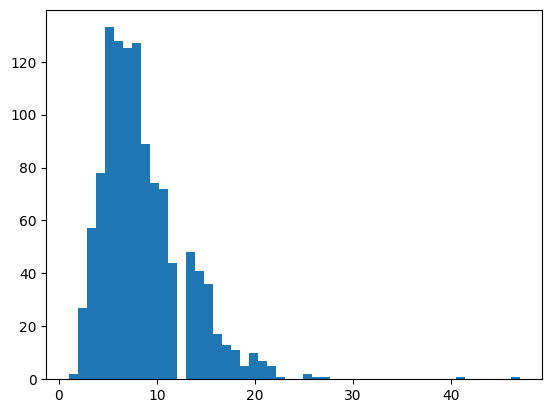

In [51]:
import matplotlib.pyplot as plt

# 문장별 단어 수 분포 확인
train_seq_lens = [len(seq.split()) for seq in clean_train_question]
plt.hist(train_seq_lens, bins=50)
plt.show()

# 최대 시퀀스 길이 설정
max_seq_len = 30


x는 clean_train_question에서 각 문장의 단어 수를 나타내는 리스트이고, y는 이러한 문장의 수를 나타내는 숫자입니다. 즉, train_seq_lens 리스트는 x이고, plt.hist 함수는 x 값을 받아서 해당 값을 구간으로 나누고 각 구간에 속한 데이터의 수를 y로 나타내는 히스토그램을 그리게 됩니다. max_seq_len은 시퀀스의 최대 길이를 나타내는 변수입니다.

In [52]:
# 전체 토큰의 수 확인
total_words = len(tokenizer.word_index) + 1
print("전체 토큰 수 : ", total_words)


전체 토큰 수 :  1168


In [53]:
# 전체 토큰의 수로 vocab_size 지정
vocab_size = total_words

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
tokenizer.fit_on_texts(clean_train_question)

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = tokenizer.texts_to_sequences(clean_train_question)
x_val = tokenizer.texts_to_sequences(clean_test_question)

In [56]:
x_val

[[37, 9, 465, 685, 793, 68, 97, 76],
 [37, 2, 691, 2, 48, 12, 154],
 [243, 89, 5, 275],
 [243, 4, 699, 89, 13, 90, 107],
 [20, 538],
 [20, 538],
 [712, 713, 7, 59, 20, 41, 119],
 [222, 279, 7, 20, 49, 56],
 [716, 472, 196],
 [],
 [721, 66, 15, 124, 30, 12, 33],
 [66, 173, 103, 379],
 [487, 117, 246, 277, 78, 33],
 [117, 246, 277, 78, 33, 559, 573, 65, 277, 78, 25, 196],
 [312, 155, 34, 171, 55, 826, 2, 26, 154],
 [387, 537, 10, 538],
 [786, 25, 196],
 [395, 782, 90, 97, 319],
 [155, 284, 14],
 [510, 155, 7, 113, 28, 78, 14],
 [548, 24, 88, 52, 174],
 [548, 321, 88, 52, 174],
 [158, 9, 385, 512, 197, 186, 76, 790, 322],
 [158, 9, 513, 23, 197, 41],
 [56, 216, 283, 90, 107],
 [799, 323, 5, 800, 801],
 [522, 369, 56, 526],
 [394, 5, 20, 526],
 [813, 265, 7, 108, 249, 500],
 [813, 265, 28, 225, 9, 108, 249, 14],
 [222, 260, 225, 324, 20, 49, 14],
 [407, 5, 20, 49, 14],
 [823, 60, 279, 7, 20, 49, 56],
 [824, 23, 536, 228],
 [408, 830, 159],
 [831, 7, 539, 540],
 [250, 833, 14],
 [250, 249, 

In [63]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성,
word_to_index = tokenizer.word_index
index_to_word = {index : word for word, index in word_to_index.items()}

index_to_word

{1: '나요',
 2: '이',
 3: '있',
 4: '는',
 5: '하',
 6: '교육',
 7: '가',
 8: '지원',
 9: '을',
 10: '에',
 11: '수',
 12: '되',
 13: '할',
 14: '어',
 15: '도',
 16: '경우',
 17: '은',
 18: '한가요',
 19: '가능',
 20: '고',
 21: '면',
 22: '어떻게',
 23: '를',
 24: '으로',
 25: '나',
 26: '없',
 27: '중',
 28: '로',
 29: '서류',
 30: '해야',
 31: '궁금',
 32: '합니다',
 33: '는데',
 34: '에서',
 35: '어떤',
 36: '한',
 37: '노트북',
 38: '졸업',
 39: '과',
 40: '진행',
 41: '해',
 42: '인가요',
 43: '인',
 44: '시',
 45: '과정',
 46: '의',
 47: '채용',
 48: '안',
 49: '싶',
 50: '수강',
 51: '다른',
 52: '먹',
 53: '받',
 54: '연계',
 55: '만',
 56: '다',
 57: '주',
 58: '가요',
 59: '자',
 60: '보',
 61: '지',
 62: '좋',
 63: '대면',
 64: '지역',
 65: '게',
 66: '공부',
 67: '기준',
 68: '것',
 69: '시간',
 70: '들',
 71: '제출',
 72: '제공',
 73: '미취',
 74: '업자',
 75: '재',
 76: '아',
 77: '합격',
 78: '했',
 79: '뭔',
 80: '추가',
 81: '검사',
 82: '수료',
 83: '비대',
 84: '일',
 85: '을까요',
 86: '테스트',
 87: '증명서',
 88: '뭐',
 89: '취업',
 90: '거',
 91: '참여',
 92: '장소',
 93: '생',
 94: '기간',
 95: '실업',
 96:

In [68]:
# <PAD> 는 0으로 추가(PAD 토큰 추가)
word_to_index['<PAD>'] = 0
index_to_word[0] = '<PAD>'

# 시퀀스 길이를 맞추기 위한 padding
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_seq_len, padding='post', truncating='post')
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=max_seq_len, padding='post', truncating='post')

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

In [72]:
pip install koreanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 43.5 MB/s eta 0:00:00


In [69]:
token_counts = [len(question.split()) for question in clean_train_question]

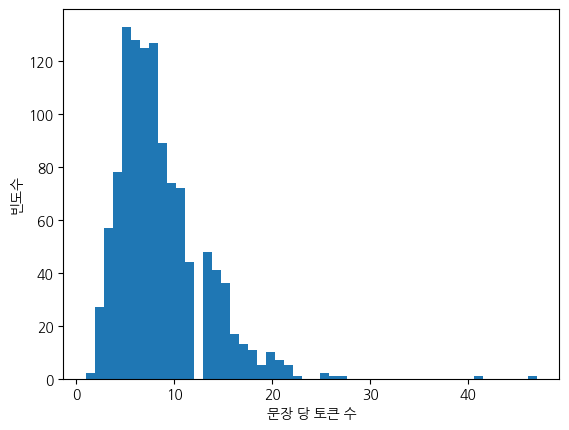

In [76]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.hist(token_counts, bins=50)
plt.xlabel('문장 당 토큰 수')
plt.ylabel('빈도수')
plt.show()


나요: 448
이: 328
있: 300
는: 227
하: 222
교육: 209
가: 208
지원: 193
을: 178
에: 169


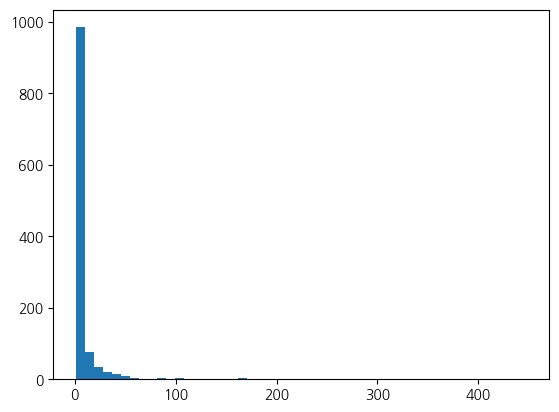

In [81]:
from collections import Counter
import matplotlib.pyplot as plt

# 단어별 빈도수 카운트
word_counts = Counter([word for seq in clean_train_question for word in seq.split()])

# 빈도수를 기준으로 내림차순 정렬한 단어 리스트
sorted_words = sorted(list(word_counts.keys()), key=lambda x: word_counts[x], reverse=True)

# 단어별 빈도수 출력
for word in sorted_words[:10]:
    print(f"{word}: {word_counts[word]}")

# 단어별 빈도수 분포 확인
plt.hist(list(word_counts.values()), bins=50)
plt.show()


* 문장별 토큰이 가장 큰 것이 57개 입니다. 

In [82]:
print(max(token_counts))


47


* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아 
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

### (2) 사전학습모델(Word2Vec)

* Pre-trained Word2Vec model
    * 이미 다운로드 받아서 제공되었습니다.
        * ko.bin, ko.tsv
    * 참고 사이트: https://github.com/Kyubyong/wordvectors
        * 모델 파일 다운로드 사이트: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg
* 사전학습 모델을 로딩하고, 
* train 데이터셋의 질문(Q)을 임베딩벡터로 만들어, 열(Column)로 추가합니다.

#### 1) 모델 로딩
* 사전 학습된 모델을 로딩 : gensim.models.Word2Vec.load()
* 로딩 후 벡터 크기를 조회합시다. .vector_size

In [ ]:
import gensim
pre_wv_model = gensim.models.Word2Vec.load(path + 'ko.bin')

In [ ]:
# 모델의 벡터크기 조회



#### 2) train 에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

### (3) 챗봇 구축
* 아래 절차대로 수행하는 함수 만들기
    * input 질문 
    * 1단계 : 모델을 이용하여 type 0, 1로 분류
    * 2단계 : 
        * train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
        * 코사인 유사도가 가장 높은 Q를 선택
        * 선택한 Q의 intent에 맵핑된 답변 중 하나를 무작위로 선택

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

* 예측을 위한 입력 형태로 변환
    * 학습을 위한 전처리 과정을 test 데이터에도 적용합니다. 

* 1단계 : type 분류

* 2단계 : 질문에 대한 벡터 만들고 코사인 유사도 계산
    * Word2Vec 사전 학습 모델로 부터 벡터 만들기

* train의 질문 벡터들과 유사도 계산
    * Word2Vec 으로 만든 벡터들과 유사도 계산

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity






#### 2) 챗봇 함수 만들기
* 위 테스트 결과를 바탕으로 코드를 정리하고 함수로 생성합니다.

In [ ]:
def get_answer2(question): 





    return

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

## 4.챗봇3

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : 챗봇2의 1단계 모델을 사용합니다.
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링
- LSTM : 3-(1) 모델을 그대로 사용합니다.

### (2) FastText 모델

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [ ]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec



#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

* 예측을 위한 입력 형태로 변환

* 예측하기

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity






#### 2) 함수로 생성하기

In [ ]:
def get_answer3(question): 







    return 

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다. 
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?
